In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path

from senet.se_resnet import se_resnet18
from utils import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [3]:
df = pd.read_csv('aug_train.csv'); len(df)

99165

# seResnet 18 style

In [4]:
arch = se_resnet18(28); arch

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace)
          (2): Linear(in_features=4, out_features=64, bias=Fa

In [5]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [6]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(stats)

In [10]:
def get_learner(data, focal=True, fp16=True):
    learn = Learner(data, arch, metrics=[accuracy_thresh, f1], 
               callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
    return learn.mixup(stack_y=False)

# 256

In [25]:
data = get_data(256, 256, 0.1, sample=None)

In [26]:
learn = get_learner(data, focal=True, fp16=True)

In [27]:
learn.model = nn.DataParallel(learn.model)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


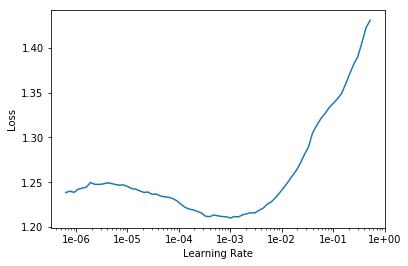

In [29]:
learn.recorder.plot()

In [30]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.094850,0.973270,0.957983,0.143310
2,0.975502,1.098745,0.951417,0.212017
3,0.851851,0.817394,0.962798,0.338529
4,0.737095,0.703073,0.967952,0.422087


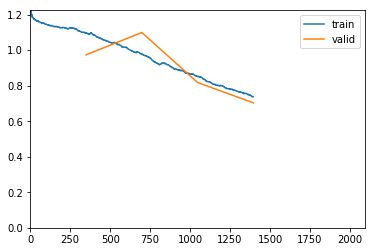

In [ ]:
%time learn.fit_one_cycle(6, slice(lr))

In [ ]:
learn.save('r18se_256');

In [ ]:
%time learn.fit_one_cycle(6, slice(lr))

In [ ]:
learn.save('r18se_256');

# 512

In [9]:
data = get_data(512, 32, 0.01, sample=None)

In [11]:
learn = get_learner(data)

In [24]:
lr=1e-2

In [25]:
%time learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,f1


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:of

KeyboardInterrupt: 

In [ ]:
learn.save('r18se_512')

In [14]:
learn.load('r18se_512');

In [15]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# Sub File

In [16]:
model_name = 'r18se'

In [17]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [18]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
np.save(model_name, preds)

In [19]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv(f'{model_name}.csv', index=False)

In [20]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 16 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,22


In [22]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f "r18se.csv" -m "seR18"

/bin/sh: 1: kaggle: not found
